In [1]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Softmax, Lambda, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.nn import local_response_normalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
np.random.seed(2022)

# 1. Datasets

In [4]:
cifair10 = tf.keras.datasets.cifar10.load_data()

(X_train, y_train), (X_test, y_test) = cifair10

In [5]:
X_train.shape

(50000, 32, 32, 3)

In [6]:
y_train.shape

(50000, 1)

In [7]:
X_test.shape

(10000, 32, 32, 3)

In [8]:
y_train.min(), y_train.max()

(0, 9)

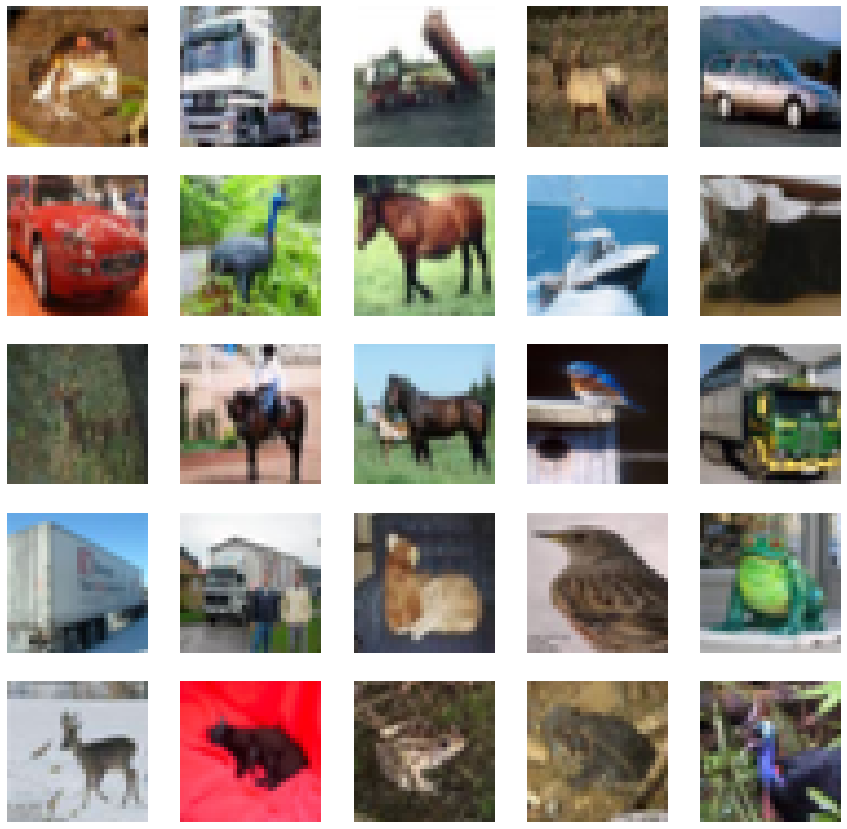

In [9]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))

for i, ax in enumerate(axes.flatten()):
    ax.axis('off')
    ax.imshow(X_train[i])

## Preprocess the dataset

In [10]:
# One-hot encoding the labels
y_train = pd.get_dummies(y_train.squeeze()).values
y_test = pd.get_dummies(y_test.squeeze()).values

In [11]:
y_train.shape

(50000, 10)

It's written in the article that:
"_Given a rectangular image, we first rescaled the image such that the shorter side was of length 256, and then cropped out the central 256×256 patch from the resulting image. We did not pre-process the images in any other way, except for subtracting the mean activity over the training set from each pixel. So we trained our network on the (centered) raw RGB values of the pixels._"

Since our images are already in the shape of 32x32 so we only subtract the mean activity over the training set from each pixel. See the next cell

In [12]:
X_train = X_train - X_train.mean(axis=0)
X_test = X_test - X_test.mean(axis=0)

## Data Augmentation

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
train_generator = ImageDataGenerator(
    rotation_range=2, 
    horizontal_flip=True,
    zoom_range=.1)

test_generator = ImageDataGenerator(
    rotation_range=2, 
    horizontal_flip=True,
    zoom_range=.1)

val_generator = ImageDataGenerator(
    rotation_range=2, 
    horizontal_flip=True,
    zoom_range=.1)



In [15]:
train_generator.fit(X_train)
test_generator.fit(X_test)
val_generator.fit(X_val)

# 2. The Architecture

In [16]:


model = Sequential([
    # 1st convolutional layer, 96 kernels of size 11×11×3 with a stride of 4 pixels
    Conv2D(filters=96, activation='relu', input_shape=(32, 32, 3), kernel_size=(11, 11), strides=(4, 4), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), padding='same'),  
    Lambda(local_response_normalization, arguments={'alpha': 1e-4, 'beta': 0.75, 'bias': 2}),  # 1st response-normalization layer
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 1st max-pooling layer


    # 2nd convolutional layer, 256 kernels of size 5 × 5 × 48
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), activation='relu', bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), padding='same'),  
    Lambda(local_response_normalization, arguments={'alpha': 1e-4, 'beta': 0.75, 'bias': 2}),  # 2nd response-normalization layer
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 2nd max-pooling layer


    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same',
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 3rd convolutional layer, 384 kernels of size 3 × 3 × 256


    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same',
           bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 4th convolutional layer, 384 kernels of size 3 × 3 × 192


    Conv2D(filters=256, kernel_size=(3, 3), strides= (1, 1), activation='relu', padding='same',
           bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 5th convolutional layer, 256 kernels of size 3 × 3 × 192
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 3rd max-pooling layer

    Flatten(),


    Dense(units=4096, activation='relu', bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), input_shape=(32, 32, 3,)),
    Dropout(rate=0.5),


    Dense(units=4096, activation='relu', bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),
    Dropout(rate=0.5),


    Dense(units=10, bias_initializer=tf.keras.initializers.Ones(), activation='softmax',
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022))
])




In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 8, 8, 96)          34944     
                                                                 
 lambda (Lambda)             (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 96)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 lambda_1 (Lambda)           (None, 4, 4, 256)         0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 256)        0         
 2D)                                                    

# 3. Details of Learning

It's written in the article that:
"_We used an equal learning rate for all layers, which we adjusted manually throughout training. The heuristic which we followed was to divide the learning rate by 10 when the validation error rate stopped improving with the current learning rate_"

In [18]:
lrr = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3
)

In [19]:
learning_rate = 0.01
batch_size = 100
epochs1 = 10
epochs2 = 25

In [20]:
model.compile(
    loss = tf.keras.losses.categorical_crossentropy, 
    optimizer = tfa.optimizers.SGDW(
        learning_rate=learning_rate, weight_decay = 0.0005, momentum=0.9, nesterov=True
    ) , 
    metrics=['accuracy']
)

In [21]:
#Training the model
model_history = model.fit_generator(
    train_generator.flow(X_train, y_train, batch_size=batch_size), 
    epochs = epochs1, 
    steps_per_epoch = X_train.shape[0]//batch_size, 
    validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
    validation_steps = len(val_generator.flow(X_val, y_val, batch_size=batch_size)), 
    callbacks = [lrr], verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


400/400 [==============================] - 31s 70ms/step - loss: 2.5203 - accuracy: 0.0993 - val_loss: 2.3026 - val_accuracy: 0.1018 - lr: 0.0100
Epoch 2/10
400/400 [==============================] - 22s 55ms/step - loss: 2.3031 - accuracy: 0.1005 - val_loss: 2.3027 - val_accuracy: 0.0979 - lr: 0.0100
Epoch 3/10
400/400 [==============================] - 22s 56ms/step - loss: 2.3030 - accuracy: 0.0995 - val_loss: 2.3030 - val_accuracy: 0.0988 - lr: 0.0100
Epoch 4/10
400/400 [==============================] - 22s 55ms/step - loss: 2.3031 - accuracy: 0.0983 - val_loss: 2.3028 - val_accuracy: 0.0998 - lr: 0.0100
Epoch 5/10
400/400 [==============================] - 22s 55ms/step - loss: 2.3028 - accuracy: 0.1002 - val_loss: 2.3027 - val_accuracy: 0.0998 - lr: 1.0000e-03
Epoch 6/10
400/400 [==============================] - 22s 55ms/step - loss: 2.3027 - accuracy: 0.0996 - val_loss: 2.3026 - val_accuracy: 0.0998 - lr: 1.0000e-03
Epoch 7/10
400/400 [==============================] - 23s 57m

## Other versions

After following the paper, the result seems to be not good. So we made a few adjustments. We used Batchnormalization instead of Local Response Normalization and epochs = 25

In [22]:

model2 = Sequential([
    # 1st convolutional layer, 96 kernels of size 11×11×3 with a stride of 4 pixels
    Conv2D(filters=96, input_shape=(32, 32, 3), kernel_size=(11, 11), strides=(4, 4), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), padding='same'),  
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 1st max-pooling layer


    # 2nd convolutional layer, 256 kernels of size 5 × 5 × 48
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), padding='same'),  
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 2nd max-pooling layer


    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same',
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 3rd convolutional layer, 384 kernels of size 3 × 3 × 256
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same',
           bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 4th convolutional layer, 384 kernels of size 3 × 3 × 192
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=256, kernel_size=(3, 3), strides= (1, 1), padding='same',
           bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 5th convolutional layer, 256 kernels of size 3 × 3 × 192
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 3rd max-pooling layer

    Flatten(),


    Dense(units=4096, bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), input_shape=(32, 32, 3,)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(rate=0.5),


    Dense(units=4096, bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(rate=0.5),


    Dense(units=10, bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),
    BatchNormalization(),
    Activation('softmax'),
])


In [23]:
model2.compile(
    loss = tf.keras.losses.categorical_crossentropy, 
    optimizer = tfa.optimizers.SGDW(
        learning_rate=learning_rate, weight_decay = 0.0005, momentum=0.9, nesterov=True
    ) , 
    metrics=['accuracy']
)

#Training the model
model2_history = model2.fit_generator(
    train_generator.flow(X_train, y_train, batch_size=batch_size), 
    epochs = epochs2, 
    steps_per_epoch = X_train.shape[0]//batch_size, 
    validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
    validation_steps = len(val_generator.flow(X_val, y_val, batch_size=batch_size)), 
    callbacks = [lrr], verbose=1)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  app.launch_new_instance()


400/400 [==============================] - 24s 56ms/step - loss: 1.6279 - accuracy: 0.4123 - val_loss: 2.3175 - val_accuracy: 0.1197 - lr: 0.0100
Epoch 2/25
400/400 [==============================] - 22s 56ms/step - loss: 1.3248 - accuracy: 0.5304 - val_loss: 2.2763 - val_accuracy: 0.1929 - lr: 0.0100
Epoch 3/25
400/400 [==============================] - 23s 56ms/step - loss: 1.2055 - accuracy: 0.5806 - val_loss: 1.8752 - val_accuracy: 0.3150 - lr: 0.0100
Epoch 4/25
400/400 [==============================] - 22s 56ms/step - loss: 1.1295 - accuracy: 0.6068 - val_loss: 1.7871 - val_accuracy: 0.3771 - lr: 0.0100
Epoch 5/25
400/400 [==============================] - 22s 56ms/step - loss: 1.0731 - accuracy: 0.6287 - val_loss: 1.5506 - val_accuracy: 0.4606 - lr: 0.0100
Epoch 6/25
400/400 [==============================] - 23s 57ms/step - loss: 1.0378 - accuracy: 0.6422 - val_loss: 1.4428 - val_accuracy: 0.5099 - lr: 0.0100
Epoch 7/25
400/400 [==============================] - 23s 58ms/step -

In [24]:
(model.predict(X_test).argmax(axis=1) == y_test.argmax(axis=1)).mean()

313/313 [==============================] - 1s 4ms/step


0.1

In [25]:
(model2.predict(X_test).argmax(axis=1) == y_test.argmax(axis=1)).mean()

313/313 [==============================] - 1s 3ms/step


0.7368

We see that after our adjustments the result are much better.

In [26]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 8, 8, 96)          34944     
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 96)         384       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 8, 8, 96)          0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 4, 4, 96)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 4, 4, 256)         614656    
                                                                 
 batch_normalization_1 (Batc  (None, 4, 4, 256)       

Try with different monitor and optimizer

In [27]:
lrr2 = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=5, min_lr=1e-5
)

In [28]:
epochs3 = 40

model3 = Sequential([
    # 1st convolutional layer, 96 kernels of size 11×11×3 with a stride of 4 pixels
    Conv2D(filters=96, input_shape=(32, 32, 3), kernel_size=(11, 11), strides=(4, 4), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), padding='same'),  
    BatchNormalization(), 
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 1st max-pooling layer


    # 2nd convolutional layer, 256 kernels of size 5 × 5 × 48
    Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1), bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), padding='same'),  
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 2nd max-pooling layer


    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same',
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 3rd convolutional layer, 384 kernels of size 3 × 3 × 256
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1), padding='same',
           bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 4th convolutional layer, 384 kernels of size 3 × 3 × 192
    BatchNormalization(),
    Activation('relu'),

    Conv2D(filters=256, kernel_size=(3, 3), strides= (1, 1), padding='same',
           bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),  # 5th convolutional layer, 256 kernels of size 3 × 3 × 192
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'),  # 3rd max-pooling layer

    Flatten(),


    Dense(units=4096, bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022), input_shape=(32, 32, 3,)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(rate=0.5),


    Dense(units=4096, bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(rate=0.5),


    Dense(units=10, bias_initializer=tf.keras.initializers.Ones(), 
           kernel_initializer=tf.keras.initializers.RandomNormal(stddev=0.01, seed=2022)),
    BatchNormalization(),
    Activation('softmax'),
])


In [29]:
model3.compile(
    loss = tf.keras.losses.categorical_crossentropy, 
    optimizer = 'adam' , 
    metrics=['accuracy']
)

#Training the model
model3_history = model3.fit_generator(
    train_generator.flow(X_train, y_train, batch_size=batch_size), 
    epochs = epochs3, 
    steps_per_epoch = X_train.shape[0]//batch_size, 
    validation_data = val_generator.flow(X_val, y_val, batch_size=batch_size), 
    validation_steps = len(val_generator.flow(X_val, y_val, batch_size=batch_size)), 
    callbacks = [lrr2], verbose=1)

(model3.predict(X_test).argmax(axis=1) == y_test.argmax(axis=1)).mean()

Epoch 1/40


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


400/400 [==============================] - 25s 59ms/step - loss: 1.6049 - accuracy: 0.4207 - val_loss: 1.9833 - val_accuracy: 0.3413 - lr: 0.0010
Epoch 2/40
400/400 [==============================] - 24s 60ms/step - loss: 1.3298 - accuracy: 0.5357 - val_loss: 1.6675 - val_accuracy: 0.4301 - lr: 0.0010
Epoch 3/40
400/400 [==============================] - 23s 58ms/step - loss: 1.2097 - accuracy: 0.5767 - val_loss: 1.3299 - val_accuracy: 0.5392 - lr: 0.0010
Epoch 4/40
400/400 [==============================] - 23s 58ms/step - loss: 1.1191 - accuracy: 0.6125 - val_loss: 1.3994 - val_accuracy: 0.5137 - lr: 0.0010
Epoch 5/40
400/400 [==============================] - 29s 72ms/step - loss: 1.0492 - accuracy: 0.6349 - val_loss: 1.1214 - val_accuracy: 0.6131 - lr: 0.0010
Epoch 6/40
400/400 [==============================] - 23s 57ms/step - loss: 0.9849 - accuracy: 0.6624 - val_loss: 1.1131 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 7/40
400/400 [==============================] - 23s 56ms/step -

0.7366